# 01__expression

in this notebook, i join enrichment data with expression data and look into how the two are related.

figures in this notebook:
- Fig 5H: volcano plot showing log2 foldchange in expression from RNA-seq with hits from our screen highlighted

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import sys
import time

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from enrich_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
rna_seq_f = "../../../data/00__rna_seq/01__processed_results/rna_seq_results.tsv"

In [4]:
index_f = "../../../data/01__design/02__final_sgRNAs/crispri_picked_sgRNAs.not_deduped.txt"

In [5]:
data_f = "../../../data/02__screen/02__enrichment_data/enrichment_values.txt"

## 1. import data

In [6]:
rna_seq = pd.read_table(rna_seq_f, sep="\t")
rna_seq.head()

transcript_id               gene_id gene_name              csf  \
0                 DIGIT                 DIGIT     DIGIT  lncRNA_good_csf   
1   ENST00000000233.9_1  ENSG00000004059.10_2      ARF5   protein_coding   
2     ENST00000000412.3     ENSG00000003056.3      M6PR   protein_coding   
3  ENST00000000442.10_1  ENSG00000173153.13_2     ESRRA   protein_coding   
4   ENST00000001008.5_1   ENSG00000004478.7_1     FKBP4   protein_coding   

  cleaner_gene_biotype cleaner_transcript_biotype   hESC_rep1   hESC_rep2  \
0     promoter_overlap           promoter_overlap    0.000000    0.025422   
1       protein_coding             protein_coding  101.476958  102.386195   
2       protein_coding             protein_coding   49.696030   46.457026   
3       protein_coding             protein_coding    1.924618    3.493033   
4       protein_coding             protein_coding   71.840722   79.489420   

    endo_rep1   endo_rep2        ...          meso_rep2   hESC_mean  \
0    4.907468    4.784695        ...           0.014741    0.012711   
1  222.677573  197.586091        ...         245.318970  101.931577   
2   31.608496   36.350968        ...          10.951882   48.076528   
3    3.499700    2.419880        ...           7.769760    2.708826   
4   33.770398   33.810736        ...          68.012268   75.665071   

    endo_mean   meso_mean  overall_mean  threshold         qval_hESC_endo  \
0    4.846082    0.007370      1.622054  expressed   0.008168525422325441   
1  210.131832  204.374142    172.145850  expressed  0.0057874417654439295   
2   33.979732   20.552771     34.203010  expressed    0.00549724038022104   
3    2.959790    7.600094      4.422903  expressed      0.814911561863725   
4   33.790567   61.985019     57.146886  expressed    0.00160853874236564   

        qval_hESC_meso endo_hESC_log2fc  meso_hESC_log2fc  
0            sleuth NA         2.529248         -0.007628  
1   0.0346694249326972         1.036458          0.996569  
2  0.13894723887027402        -0.488514         -1.187160  
3   0.0241642757995681         0.094461          1.213390  
4   0.0935556001786738        -1.139873         -0.283561  

[5 rows x 21 columns]

In [7]:
data = pd.read_table(data_f, sep="\t")
data.head()

group_id   ctrl_status  endo_ctrl_val      gene_name  \
0  NC_000001.11:+:100894913  experimental          False   RP4-549L20.3   
1  NC_000001.11:+:100995473  experimental          False  RP11-421L21.2   
2  NC_000001.11:+:101025906  experimental          False  RP11-421L21.3   
3  NC_000001.11:+:101072856  experimental          False  RP11-421L21.3   
4  NC_000001.11:+:101081966  experimental          False  RP11-421L21.3   

                              transcript_name  BFP+_enrichment__rep1_med  \
0                            RP4-549L20.3-001                   1.261594   
1                           RP11-421L21.2-001                   0.963562   
2  ['RP11-421L21.3-005', 'RP11-421L21.3-004']                   4.489928   
3  ['RP11-421L21.3-007', 'RP11-421L21.3-001']                   1.077730   
4                           RP11-421L21.3-003                   1.440428   

   BFP+_enrichment__rep1_std  BFP+_score__rep1  BFP+_score_rank__rep1  \
0                   0.411119          1.261594                 7931.0   
1                   0.143685          0.963562                 9492.0   
2                   0.969815          4.489928                  117.0   
3                   0.753499          1.077730                 8965.0   
4                   1.885529          1.440428                 6832.0   

   BFP+_enrichment__rep2_med      ...       BFP+_score_rank__rep2  \
0                   1.286150      ...                      7342.0   
1                   2.637054      ...                       484.0   
2                   4.524770      ...                        29.0   
3                   1.182456      ...                      8175.0   
4                   1.620508      ...                      4445.0   

   BFP+_score__mean  BFP+_score_rank__mean  ctrl_status_fixed  stringent_filt  \
0          1.273872                 8513.0       experimental           False   
1          1.800308                 3843.0       experimental           False   
2          4.507349                   27.0       experimental            True   
3          1.130093                 9496.0       experimental           False   
4          1.530468                 6213.0       experimental            True   

  pval__rep1  pval__rep2  combined_pval      padj  neg_log_padj  
0        NaN         NaN            NaN       NaN           NaN  
1        NaN         NaN            NaN       NaN           NaN  
2   0.006494    0.002498       0.000091  0.006565      2.182735  
3        NaN         NaN            NaN       NaN           NaN  
4   0.890110    0.633367       0.866214  0.990306      0.004231  

[5 rows x 22 columns]

In [8]:
index = pd.read_table(index_f)
print(len(index))
print(len(index.tss_id.unique()))

129351
10719


## 2. merge enrichment data (which is grouped by TSS group, which can target multiple transcripts) with transcript-level information in index (in order to merge w/ RNA-seq)
since some TSS groups target multiple transcripts, split these up so that we can easily join with the RNA-seq data on transcript_id

In [9]:
index_sub = index[["tss_id", "gene_name", "gene_id", "transcript_name", "transcript_id"]].drop_duplicates()
print(len(index_sub))
print(len(index_sub.tss_id.unique()))
index_sub.head()

12933
10719


tss_id      gene_name              gene_id  \
0   NC_000001.11:+:100894913   RP4-549L20.3  ENSG00000273204.1_1   
10  NC_000001.11:+:100995473  RP11-421L21.2  ENSG00000235795.1_1   
20  NC_000001.11:+:101025906  RP11-421L21.3  ENSG00000233184.6_1   
21  NC_000001.11:+:101025906  RP11-421L21.3  ENSG00000233184.6_1   
40  NC_000001.11:+:101072856  RP11-421L21.3  ENSG00000233184.6_1   

      transcript_name        transcript_id  
0    RP4-549L20.3-001  ENST00000609247.1_1  
10  RP11-421L21.2-001  ENST00000414686.1_1  
20  RP11-421L21.3-004  ENST00000446527.5_1  
21  RP11-421L21.3-005  ENST00000453011.5_1  
40  RP11-421L21.3-001  ENST00000449473.2_1

In [10]:
data_split = tidy_split(data, "group_id", sep=",", keep=False)
data_split["group_id"] = data_split.apply(clean_split_col, col="group_id", axis=1)
data_split.head(10)

group_id   ctrl_status  endo_ctrl_val      gene_name  \
0  NC_000001.11:+:100894913  experimental          False   RP4-549L20.3   
1  NC_000001.11:+:100995473  experimental          False  RP11-421L21.2   
2  NC_000001.11:+:101025906  experimental          False  RP11-421L21.3   
3  NC_000001.11:+:101072856  experimental          False  RP11-421L21.3   
4  NC_000001.11:+:101081966  experimental          False  RP11-421L21.3   
5  NC_000001.11:+:101243119  experimental          False    RP4-575N6.5   
6  NC_000001.11:+:101350049  experimental          False      LINC01307   
7  NC_000001.11:+:101639586  experimental          False   RP11-411H5.1   
8    NC_000001.11:+:1055020  experimental          False   RP11-54O7.14   
9  NC_000001.11:+:105956718  experimental          False   RP5-947P14.1   

                              transcript_name  BFP+_enrichment__rep1_med  \
0                            RP4-549L20.3-001                   1.261594   
1                           RP11-421L21.2-001                   0.963562   
2  ['RP11-421L21.3-005', 'RP11-421L21.3-004']                   4.489928   
3  ['RP11-421L21.3-007', 'RP11-421L21.3-001']                   1.077730   
4                           RP11-421L21.3-003                   1.440428   
5                             RP4-575N6.5-001                   2.460797   
6                               LINC01307-001                   1.628924   
7                            RP11-411H5.1-002                   1.299062   
8                            RP11-54O7.14-001                   1.843228   
9    ['RP5-947P14.1-010', 'RP5-947P14.1-009']                   2.294645   

   BFP+_enrichment__rep1_std  BFP+_score__rep1  BFP+_score_rank__rep1  \
0                   0.411119          1.261594                 7931.0   
1                   0.143685          0.963562                 9492.0   
2                   0.969815          4.489928                  117.0   
3                   0.753499          1.077730                 8965.0   
4                   1.885529          1.440428                 6832.0   
5                   1.531855          2.460797                 1893.0   
6                   0.559997          1.628924                 5604.0   
7                   0.120786          1.299062                 7704.0   
8                   0.640394          1.843228                 4381.0   
9                   0.202520          2.294645                 2406.0   

   BFP+_enrichment__rep2_med      ...       BFP+_score_rank__rep2  \
0                   1.286150      ...                      7342.0   
1                   2.637054      ...                       484.0   
2                   4.524770      ...                        29.0   
3                   1.182456      ...                      8175.0   
4                   1.620508      ...                      4445.0   
5                   1.616215      ...                      4484.0   
6                   0.968451      ...                      9584.0   
7                   1.782306      ...                      3248.0   
8                   0.983647      ...                      9504.0   
9                   1.545266      ...                      5052.0   

   BFP+_score__mean  BFP+_score_rank__mean  ctrl_status_fixed  stringent_filt  \
0          1.273872                 8513.0       experimental           False   
1          1.800308                 3843.0       experimental           False   
2          4.507349                   27.0       experimental            True   
3          1.130093                 9496.0       experimental           False   
4          1.530468                 6213.0       experimental            True   
5          2.038506                 2292.0       experimental           False   
6          1.298687                 8323.0       experimental           False   
7          1.540684                 6121.0       experimental           False   
8          1.413438                 7351.0       experimental  

In [11]:
data.columns

Index(['group_id', 'ctrl_status', 'endo_ctrl_val', 'gene_name',
       'transcript_name', 'BFP+_enrichment__rep1_med',
       'BFP+_enrichment__rep1_std', 'BFP+_score__rep1',
       'BFP+_score_rank__rep1', 'BFP+_enrichment__rep2_med',
       'BFP+_enrichment__rep2_std', 'BFP+_score__rep2',
       'BFP+_score_rank__rep2', 'BFP+_score__mean', 'BFP+_score_rank__mean',
       'ctrl_status_fixed', 'stringent_filt', 'pval__rep1', 'pval__rep2',
       'combined_pval', 'padj', 'neg_log_padj'],
      dtype='object')

In [12]:
data_sub = data_split[["group_id", "ctrl_status", "endo_ctrl_val", "BFP+_score__rep1",
                       "BFP+_score_rank__rep1", "BFP+_score__rep2",
                       "BFP+_score_rank__rep2", "BFP+_score__mean", "BFP+_score_rank__mean", "ctrl_status_fixed", 
                       "pval__rep1", "pval__rep2", "combined_pval", "padj", "neg_log_padj"]].drop_duplicates()
print(len(data_sub))
data_sub.sample(5)

11026


group_id   ctrl_status  endo_ctrl_val  \
7466    NC_000015.10:-:62835392  experimental          False   
1465    NC_000002.12:-:19026930  experimental          False   
2613   NC_000004.12:-:182143825  experimental          False   
10775              sgRNA:053106      scramble          False   
7041     NC_000014.9:-:50961990  experimental          False   

       BFP+_score__rep1  BFP+_score_rank__rep1  BFP+_score__rep2  \
7466           1.817722                 4550.0          2.152652   
1465           0.888652                 9785.0          1.643561   
2613           1.658082                 5451.0          0.683358   
10775          0.353581                10897.0          1.411339   
7041           1.998966                 3606.0          2.532782   

       BFP+_score_rank__rep2  BFP+_score__mean  BFP+_score_rank__mean  \
7466                  1465.0          1.985187                 2574.0   
1465                  4257.0          1.266107                 8567.0   
2613                 10646.0          1.170720                 9228.0   
10775                 6228.0          0.882460                10517.0   
7041                   616.0          2.265874                 1279.0   

      ctrl_status_fixed  pval__rep1  pval__rep2  combined_pval      padj  \
7466       experimental         NaN         NaN            NaN       NaN   
1465       experimental         NaN         NaN            NaN       NaN   
2613       experimental         NaN         NaN            NaN       NaN   
10775          scramble         NaN         NaN            NaN       NaN   
7041       experimental    0.580919    0.068432       0.182084  0.562848   

       neg_log_padj  
7466            NaN  
1465            NaN  
2613            NaN  
10775           NaN  
7041       0.249609

In [13]:
data_sub = data_sub[data_sub["ctrl_status"] != "scramble"]
len(data_sub)

10542

In [14]:
data_clean = data_sub.merge(index_sub, left_on="group_id", right_on="tss_id", how="left")
print(len(data_clean))
data_clean.head()

12697


group_id   ctrl_status  endo_ctrl_val  BFP+_score__rep1  \
0  NC_000001.11:+:100894913  experimental          False          1.261594   
1  NC_000001.11:+:100995473  experimental          False          0.963562   
2  NC_000001.11:+:101025906  experimental          False          4.489928   
3  NC_000001.11:+:101025906  experimental          False          4.489928   
4  NC_000001.11:+:101072856  experimental          False          1.077730   

   BFP+_score_rank__rep1  BFP+_score__rep2  BFP+_score_rank__rep2  \
0                 7931.0          1.286150                 7342.0   
1                 9492.0          2.637054                  484.0   
2                  117.0          4.524770                   29.0   
3                  117.0          4.524770                   29.0   
4                 8965.0          1.182456                 8175.0   

   BFP+_score__mean  BFP+_score_rank__mean ctrl_status_fixed  pval__rep1  \
0          1.273872                 8513.0      experimental         NaN   
1          1.800308                 3843.0      experimental         NaN   
2          4.507349                   27.0      experimental    0.006494   
3          4.507349                   27.0      experimental    0.006494   
4          1.130093                 9496.0      experimental         NaN   

   pval__rep2  combined_pval      padj  neg_log_padj  \
0         NaN            NaN       NaN           NaN   
1         NaN            NaN       NaN           NaN   
2    0.002498       0.000091  0.006565      2.182735   
3    0.002498       0.000091  0.006565      2.182735   
4         NaN            NaN       NaN           NaN   

                     tss_id      gene_name              gene_id  \
0  NC_000001.11:+:100894913   RP4-549L20.3  ENSG00000273204.1_1   
1  NC_000001.11:+:100995473  RP11-421L21.2  ENSG00000235795.1_1   
2  NC_000001.11:+:101025906  RP11-421L21.3  ENSG00000233184.6_1   
3  NC_000001.11:+:101025906  RP11-421L21.3  ENSG00000233184.6_1   
4  NC_000001.11:+:101072856  RP11-421L21.3  ENSG00000233184.6_1   

     transcript_name        transcript_id  
0   RP4-549L20.3-001  ENST00000609247.1_1  
1  RP11-421L21.2-001  ENST00000414686.1_1  
2  RP11-421L21.3-004  ENST00000446527.5_1  
3  RP11-421L21.3-005  ENST00000453011.5_1  
4  RP11-421L21.3-001  ENST00000449473.2_1

In [15]:
data_clean[pd.isnull(data_clean["transcript_id"])]

Empty DataFrame
Columns: [group_id, ctrl_status, endo_ctrl_val, BFP+_score__rep1, BFP+_score_rank__rep1, BFP+_score__rep2, BFP+_score_rank__rep2, BFP+_score__mean, BFP+_score_rank__mean, ctrl_status_fixed, pval__rep1, pval__rep2, combined_pval, padj, neg_log_padj, tss_id, gene_name, gene_id, transcript_name, transcript_id]
Index: []

## 3. merge w/ RNA-seq data using transcript_id

In [16]:
data_w_seq = data_clean.merge(rna_seq, on=["gene_name", "gene_id", "transcript_id"], 
                              how="left").sort_values(by="BFP+_score_rank__mean")
data_w_seq.drop(["meso_mean", "overall_mean", "qval_hESC_meso", "meso_hESC_log2fc"], axis=1, inplace=True)
data_w_seq.head(20)

group_id   ctrl_status  endo_ctrl_val  BFP+_score__rep1  \
5348   NC_000008.11:+:54457934       control           True        232.279434   
2749   NC_000003.12:-:27722707       control           True        156.570722   
2748   NC_000003.12:-:27722322       control           True         43.594914   
9203   NC_000016.10:+:23452748  experimental          False          3.702626   
9204   NC_000016.10:+:23452748  experimental          False          3.702626   
9202   NC_000016.10:+:23452748  experimental          False          3.702626   
12520  NC_000023.11:-:11111137  experimental          False         21.636555   
12521  NC_000023.11:-:11111137  experimental          False         21.636555   
11363  NC_000019.10:-:23416046  experimental          False         33.820033   
11365  NC_000019.10:-:23416046  experimental          False         33.820033   
11366  NC_000019.10:-:23416046  experimental          False         33.820033   
11364  NC_000019.10:-:23416046  experimental          False         33.820033   
11367  NC_000019.10:-:23416046  experimental          False         33.820033   
11368  NC_000019.10:-:23416046  experimental          False         33.820033   
11369  NC_000019.10:-:23416046  experimental          False         33.820033   
11370  NC_000019.10:-:23416046  experimental          False         33.820033   
6952   NC_000011.10:+:90223166  experimental          False          4.561471   
2427   NC_000003.12:+:27712918  experimental          False         12.879865   
9123   NC_000015.10:-:90935157  experimental          False          6.470644   
12335  NC_000022.11:-:38681855  experimental          False         19.532816   

       BFP+_score_rank__rep1  BFP+_score__rep2  BFP+_score_rank__rep2  \
5348                     1.0        313.295214                    1.0   
2749                     2.0         22.862835                    5.0   
2748                     3.0        112.574256                    2.0   
9203                   312.0         62.143087                    3.0   
9204                   312.0         62.143087                    3.0   
9202                   312.0         62.143087                    3.0   
12520                    6.0         15.060327                    7.0   
12521                    6.0         15.060327                    7.0   
11363                    4.0          2.081009                 1732.0   
11365                    4.0          2.081009                 1732.0   
11366                    4.0          2.081009                 1732.0   
11364                    4.0          2.081009                 1732.0   
11367                    4.0          2.081009                 1732.0   
11368                    4.0          2.081009                 1732.0   
11369                    4.0          2.081009                 1732.0   
11370                    4.0          2.081009                 1732.0   
6952                   102.0         31.045323                    4.0   
2427                     9.0         10.795374                   10.0   
9123                    31.0         17.070588                    6.0   
12335                    7.0          2.845626                  308.0   

       BFP+_score__mean  BFP+_score_rank__mean ctrl_status_fixed  \
5348         272.787324                    1.0           control   
2749          89.716778                    2.0           control   
2748          78.084585                    3.0           control   
9203          32.922856                    4.0      experimental   
9204          32.922856                    4.0      experimental   
9202          32.922856                    4.0      experimental   
12520         18.348441                    5.0      experimental   
12521         18.348441                    5.0      experimental   
11363         17.950521                    6.0      experimental   
11365         17.950521                    6.0      experimental   
11366         17.950521               

In [17]:
data_w_seq[data_w_seq["gene_name"] == "DIGIT"]

group_id   ctrl_status  endo_ctrl_val  BFP+_score__rep1  \
8402  NC_000014.9:+:94770641  experimental          False          4.053715   

      BFP+_score_rank__rep1  BFP+_score__rep2  BFP+_score_rank__rep2  \
8402                  199.0          3.070025                  184.0   

      BFP+_score__mean  BFP+_score_rank__mean ctrl_status_fixed  \
8402           3.56187                   77.0      experimental   

           ...         hESC_rep2  endo_rep1  endo_rep2  meso_rep1  meso_rep2  \
8402       ...          0.025422   4.907468   4.784695        0.0   0.014741   

     hESC_mean endo_mean  threshold        qval_hESC_endo endo_hESC_log2fc  
8402  0.012711  4.846082  expressed  0.008168525422325441         2.529248  

[1 rows x 34 columns]

In [18]:
nulls = data_w_seq[(pd.isnull(data_w_seq["transcript_id"])) & (data_w_seq["ctrl_status"] != "scramble")]
len(nulls)

0

In [19]:
data_w_seq[data_w_seq["gene_name"] == "RP11-474D1.4"][["group_id", "gene_name", "transcript_name", "cleaner_transcript_biotype", "cleaner_gene_biotype"]]

group_id     gene_name   transcript_name  \
7719  NC_000012.12:-:130045056  RP11-474D1.4  RP11-474D1.4-001   

     cleaner_transcript_biotype cleaner_gene_biotype  
7719           promoter_overlap     promoter_overlap

## 4. plot expression change vs. enrichment score

In [20]:
experimental = data_w_seq[data_w_seq["ctrl_status_fixed"] == "experimental"]
control = data_w_seq[data_w_seq["ctrl_status_fixed"] == "control"]

sox17 = control[control["transcript_name"] == "SOX17-001"]
foxa2 = control[control["transcript_name"] == "FOXA2-002"]
gata6 = control[control["transcript_name"] == "GATA6-001"]
eomes1 = control[control["transcript_name"] == "EOMES-004"]
eomes2 = control[control["transcript_name"] == "EOMES-001"]
gsc = control[control["transcript_name"] == "GSC-001"]

In [21]:
control.sort_values(by="BFP+_score__mean", ascending=False)[["transcript_name", "gene_name"]].head(10)

transcript_name gene_name
5348        SOX17-001     SOX17
2749        EOMES-004     EOMES
2748        EOMES-001     EOMES
11764       FOXA2-002     FOXA2
8627          GSC-001       GSC
10644       GATA6-001     GATA6
322         MIXL1-001     MIXL1
11726        BMP2-001      BMP2
1887          FN1-011       FN1
1519        EPCAM-002     EPCAM

In [22]:
fig = plt.figure(figsize=(4,1.5))

plt.axhline(y=0, linestyle="dashed", color="black", linewidth=1)
plt.scatter(experimental["BFP+_score__mean"], experimental["endo_hESC_log2fc"], s=10,
            color="darkgray", alpha=0.9)
plt.scatter(control["BFP+_score__mean"], control["endo_hESC_log2fc"], s=10,
            color="green", alpha=1)

# plot controls
plt.scatter(sox17["BFP+_score__mean"], sox17["endo_hESC_log2fc"], s=10,
         color="green", alpha=1, linewidths=1, edgecolors="black")
plt.annotate(s="SOX17", xy=(sox17["BFP+_score__mean"], sox17["endo_hESC_log2fc"]),
             xytext=(-15, -10), textcoords="offset points", fontsize=7)

plt.scatter(foxa2["BFP+_score__mean"], foxa2["endo_hESC_log2fc"], s=10,
         color="green", alpha=1, linewidths=1, edgecolors="black")
plt.annotate(s="FOXA2", xy=(foxa2["BFP+_score__mean"], foxa2["endo_hESC_log2fc"]),
             xytext=(2, -5), textcoords="offset points", fontsize=7)

plt.scatter(gsc["BFP+_score__mean"], gsc["endo_hESC_log2fc"], s=10,
         color="green", alpha=1, linewidths=1, edgecolors="black")
plt.annotate(s="GSC", xy=(gsc["BFP+_score__mean"], gsc["endo_hESC_log2fc"]),
             xytext=(2, -5), textcoords="offset points", fontsize=7)

plt.scatter(gata6["BFP+_score__mean"], gata6["endo_hESC_log2fc"], s=10,
         color="green", alpha=1, linewidths=1, edgecolors="black")
plt.annotate(s="GATA6", xy=(gata6["BFP+_score__mean"], gata6["endo_hESC_log2fc"]),
             xytext=(-10, 6), textcoords="offset points", fontsize=7)

plt.scatter(eomes1["BFP+_score__mean"], eomes1["endo_hESC_log2fc"], s=10,
         color="green", alpha=1, linewidths=1, edgecolors="black")
plt.scatter(eomes2["BFP+_score__mean"], eomes2["endo_hESC_log2fc"], s=10,
         color="green", alpha=1, linewidths=1, edgecolors="black")
plt.annotate(s="EOMES", xy=(eomes1["BFP+_score__mean"], eomes1["endo_hESC_log2fc"]),
             xytext=(-15, -10), textcoords="offset points", fontsize=7)

plt.xlabel("screen transcript enrichment score")
plt.ylabel("log2(endo tpm/hESC tpm)")

plt.xscale('symlog')
 
# #plt.xlim((-0.05, 1.7))
#fig.savefig("FigS5D.pdf", dpi="figure", bbox_inches="tight")

## 5. plot expression, tissue-specificity & expression change for hits vs. non hits

In [23]:
data_w_seq["is_hit"] = data_w_seq.apply(is_hit, axis=1)
data_w_seq.is_hit.value_counts()

no hit           11196
lenient hit       1428
stringent hit       73
Name: is_hit, dtype: int64

In [24]:
hits = data_w_seq[data_w_seq["is_hit"] == "stringent hit"]
print(len(hits.group_id.unique()))
hits.head()

54


group_id   ctrl_status  endo_ctrl_val  BFP+_score__rep1  \
5348  NC_000008.11:+:54457934       control           True        232.279434   
2749  NC_000003.12:-:27722707       control           True        156.570722   
2748  NC_000003.12:-:27722322       control           True         43.594914   
9203  NC_000016.10:+:23452748  experimental          False          3.702626   
9204  NC_000016.10:+:23452748  experimental          False          3.702626   

      BFP+_score_rank__rep1  BFP+_score__rep2  BFP+_score_rank__rep2  \
5348                    1.0        313.295214                    1.0   
2749                    2.0         22.862835                    5.0   
2748                    3.0        112.574256                    2.0   
9203                  312.0         62.143087                    3.0   
9204                  312.0         62.143087                    3.0   

      BFP+_score__mean  BFP+_score_rank__mean ctrl_status_fixed  \
5348        272.787324                    1.0           control   
2749         89.716778                    2.0           control   
2748         78.084585                    3.0           control   
9203         32.922856                    4.0      experimental   
9204         32.922856                    4.0      experimental   

          ...         endo_rep1   endo_rep2  meso_rep1  meso_rep2  hESC_mean  \
5348      ...        140.150442  128.702584   0.000000   0.048871   0.110290   
2749      ...         95.443310  106.972272   0.015622   0.000000   0.123413   
2748      ...         85.411152   84.965348   0.025561   0.033138   0.084601   
9203      ...          1.169701    0.829991   1.102973   1.798715   0.956400   
9204      ...          2.440466    2.524508   2.211605   2.992082   1.391981   

       endo_mean  threshold        qval_hESC_endo endo_hESC_log2fc  \
5348  134.426513  expressed  0.000991006472787698         6.930430   
2749  101.207791  expressed    0.0217931946808208         6.507473   
2748   85.188250  expressed  0.000510199113682609         6.312255   
9203    0.999846  expressed   0.18145252810327697         0.031688   
9204    2.482487  expressed    0.0347336116955254         0.541912   

             is_hit  
5348  stringent hit  
2749  stringent hit  
2748  stringent hit  
9203  stringent hit  
9204  stringent hit  

[5 rows x 35 columns]

In [45]:
hits[["gene_name", "ctrl_status_fixed", "cleaner_gene_biotype", "BFP+_score__mean"]].drop_duplicates().sort_values(by="BFP+_score__mean", ascending=False)

gene_name ctrl_status_fixed cleaner_gene_biotype  BFP+_score__mean
5348           SOX17           control       protein_coding        272.787324
2749           EOMES           control       protein_coding         89.716778
2748           EOMES           control       protein_coding         78.084585
9203    CTD-2270L9.4      experimental     promoter_overlap         32.922856
12520   RP11-120D5.1      experimental     promoter_overlap         18.348441
6952   RP11-121L10.2      experimental     promoter_overlap         17.803397
2427   RP11-222K16.2      experimental           intergenic         11.837620
9123      AC068831.3      experimental   transcript_overlap         11.770616
12335   RP3-508I15.9      experimental     promoter_overlap         11.189221
9790      PITPNA-AS1      experimental     promoter_overlap         10.073605
11764          FOXA2           control       protein_coding         10.031513
2774      ACVR2B-AS1      experimental     promoter_overlap          8.452321
11984      LINC01424      experimental     promoter_overlap          6.510816
10737         PMAIP1      experimental       protein_coding          5.644577
1042       FOXD3-AS1      experimental   transcript_overlap          5.319862
10268     AC007952.4      experimental           intergenic          5.205776
27       LAMTOR5-AS1      experimental   transcript_overlap          5.129643
12066      LINC00479      experimental     promoter_overlap          4.961840
8146           FOXO1      experimental       protein_coding          4.939258
8627             GSC           control       protein_coding          4.857862
10644          GATA6           control       protein_coding          4.770642
2      RP11-421L21.3      experimental     promoter_overlap          4.507349
11119   CTC-492K19.4      experimental   transcript_overlap          4.474991
10652   RP11-705O1.8      experimental     promoter_overlap          4.408891
7719    RP11-474D1.4      experimental     promoter_overlap          4.402693
11270  LLNLR-260G6.1      experimental   transcript_overlap          4.379257
6914      KCTD21-AS1      experimental     promoter_overlap          4.269017
540     RP3-510D11.2      experimental   transcript_overlap          4.183058
3726   RP11-414H23.2      experimental           intergenic          4.174521
6663    RP11-685M7.3      experimental     promoter_overlap          4.144443
3875    RP11-541P9.3      experimental     promoter_overlap          4.127385
5463      RP11-1C8.4      experimental     promoter_overlap          4.025898
11100  CTD-3220F14.2      experimental   transcript_overlap          3.982744
8363   CTD-3075F15.1      experimental     promoter_overlap          3.908216
11833   RP1-148H17.1      experimental           intergenic          3.898444
322            MIXL1           control       protein_coding          3.871858
6794    RP11-23F23.2      experimental           intergenic          3.827396
4868      AC002066.1      experimental   transcript_overlap          3.827183
5222            PVT1      experimental   transcript_overlap          3.792359
1044       FOXD3-AS1      experimental   transcript_overlap          3.778208
10194        SLC16A3      experimental       protein_coding          3.726568
8784   RP11-299H22.6      experimental           intergenic          3.637825
800     RP5-1056L3.1      experimental     promoter_overlap          3.600550
10548      LINC00511      experimental   transcript_overlap          3.576203
12115   KB-1440D3.14      experimental          gene_nearby          3.572189
5372       LINC00967      experimental           intergenic          3.567276
8402           DIGIT      experimental     promoter_overlap          3.561870
2539       LINC00635      experimental           intergenic          3.531763
785    RP11-533E19.7      experimental     promoter_overlap          3.531108
1659      AC011753.5      experimental   transcript_overlap          3.487550
2367       LINC00969      experim

In [26]:
hits[hits["ctrl_status_fixed"] == "control"]

group_id ctrl_status  endo_ctrl_val  BFP+_score__rep1  \
5348    NC_000008.11:+:54457934     control           True        232.279434   
2749    NC_000003.12:-:27722707     control           True        156.570722   
2748    NC_000003.12:-:27722322     control           True         43.594914   
11764   NC_000020.11:-:22584571     control           True          7.851166   
8627     NC_000014.9:-:94770237     control           True          5.926591   
10644   NC_000018.10:+:22169434     control           True          5.901311   
322    NC_000001.11:+:226223663     control           True          4.850050   

       BFP+_score_rank__rep1  BFP+_score__rep2  BFP+_score_rank__rep2  \
5348                     1.0        313.295214                    1.0   
2749                     2.0         22.862835                    5.0   
2748                     3.0        112.574256                    2.0   
11764                   15.0         12.211860                    8.0   
8627                    38.0          3.789133                   59.0   
10644                   39.0          3.639973                   71.0   
322                     83.0          2.893667                  277.0   

       BFP+_score__mean  BFP+_score_rank__mean ctrl_status_fixed  \
5348         272.787324                    1.0           control   
2749          89.716778                    2.0           control   
2748          78.084585                    3.0           control   
11764         10.031513                   12.0           control   
8627           4.857862                   25.0           control   
10644          4.770642                   26.0           control   
322            3.871858                   58.0           control   

           ...         endo_rep1   endo_rep2     meso_rep1   meso_rep2  \
5348       ...        140.150442  128.702584  0.000000e+00    0.048871   
2749       ...         95.443310  106.972272  1.562174e-02    0.000000   
2748       ...         85.411152   84.965348  2.556060e-02    0.033138   
11764      ...         86.518163   85.669876  1.492126e-08    0.087575   
8627       ...        176.079187  170.095448  5.564027e-01    0.931311   
10644      ...        113.845418  115.785933  2.499071e-01    0.160848   
322        ...         80.498659   75.008413  4.259201e+02  461.670645   

       hESC_mean   endo_mean  threshold          qval_hESC_endo  \
5348    0.110290  134.426513  expressed    0.000991006472787698   
2749    0.123413  101.207791  expressed      0.0217931946808208   
2748    0.084601   85.188250  expressed    0.000510199113682609   
11764   0.155338   86.094020  expressed     0.00305611560228497   
8627    0.158873  173.087318  expressed    0.000425400288227333   
10644   0.064092  114.815676  expressed     0.00400849091163016   
322     0.850461   77.753536  expressed  0.00045037551224103397   

      endo_hESC_log2fc         is_hit  
5348          6.930430  stringent hit  
2749          6.507473  stringent hit  
2748          6.312255  stringent hit  
11764         6.236187  stringent hit  
8627          7.230944  stringent hit  
10644         6.766064  stringent hit  
322           5.411388  stringent hit  

[7 rows x 35 columns]

In [27]:
print(len(hits[hits["ctrl_status_fixed"] == "control"]))
hits[hits["ctrl_status_fixed"] == "control"].sort_values(by="group_id")

7


group_id ctrl_status  endo_ctrl_val  BFP+_score__rep1  \
322    NC_000001.11:+:226223663     control           True          4.850050   
2748    NC_000003.12:-:27722322     control           True         43.594914   
2749    NC_000003.12:-:27722707     control           True        156.570722   
5348    NC_000008.11:+:54457934     control           True        232.279434   
8627     NC_000014.9:-:94770237     control           True          5.926591   
10644   NC_000018.10:+:22169434     control           True          5.901311   
11764   NC_000020.11:-:22584571     control           True          7.851166   

       BFP+_score_rank__rep1  BFP+_score__rep2  BFP+_score_rank__rep2  \
322                     83.0          2.893667                  277.0   
2748                     3.0        112.574256                    2.0   
2749                     2.0         22.862835                    5.0   
5348                     1.0        313.295214                    1.0   
8627                    38.0          3.789133                   59.0   
10644                   39.0          3.639973                   71.0   
11764                   15.0         12.211860                    8.0   

       BFP+_score__mean  BFP+_score_rank__mean ctrl_status_fixed  \
322            3.871858                   58.0           control   
2748          78.084585                    3.0           control   
2749          89.716778                    2.0           control   
5348         272.787324                    1.0           control   
8627           4.857862                   25.0           control   
10644          4.770642                   26.0           control   
11764         10.031513                   12.0           control   

           ...         endo_rep1   endo_rep2     meso_rep1   meso_rep2  \
322        ...         80.498659   75.008413  4.259201e+02  461.670645   
2748       ...         85.411152   84.965348  2.556060e-02    0.033138   
2749       ...         95.443310  106.972272  1.562174e-02    0.000000   
5348       ...        140.150442  128.702584  0.000000e+00    0.048871   
8627       ...        176.079187  170.095448  5.564027e-01    0.931311   
10644      ...        113.845418  115.785933  2.499071e-01    0.160848   
11764      ...         86.518163   85.669876  1.492126e-08    0.087575   

       hESC_mean   endo_mean  threshold          qval_hESC_endo  \
322     0.850461   77.753536  expressed  0.00045037551224103397   
2748    0.084601   85.188250  expressed    0.000510199113682609   
2749    0.123413  101.207791  expressed      0.0217931946808208   
5348    0.110290  134.426513  expressed    0.000991006472787698   
8627    0.158873  173.087318  expressed    0.000425400288227333   
10644   0.064092  114.815676  expressed     0.00400849091163016   
11764   0.155338   86.094020  expressed     0.00305611560228497   

      endo_hESC_log2fc         is_hit  
322           5.411388  stringent hit  
2748          6.312255  stringent hit  
2749          6.507473  stringent hit  
5348          6.930430  stringent hit  
8627          7.230944  stringent hit  
10644         6.766064  stringent hit  
11764         6.236187  stringent hit  

[7 rows x 35 columns]

In [28]:
print(len(hits[~hits["endo_ctrl_val"]]))

66


In [29]:
len(hits[hits["ctrl_status_fixed"] == "control"]["gene_id"].unique())

6

In [30]:
len(hits[~hits["endo_ctrl_val"]]["gene_id"].unique())

46

In [31]:
data_w_seq["endo_hESC_abslog2fc"] = np.abs(data_w_seq["endo_hESC_log2fc"])

0.08797655015631334
0.01693972739890418


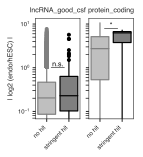

In [32]:
order = ["lncRNA_good_csf", "protein_coding"]
hue_order = ["no hit", "stringent hit"]
pal = {"no hit": "gray", "lenient hit": sns.color_palette("Set2")[2], "stringent hit": "black"}

fig, axarr = plt.subplots(figsize=(1.75, 1.85), nrows=1, ncols=2, sharey=True)

for i, csf in enumerate(order):
    ax = axarr[i]
    sub = data_w_seq[data_w_seq["csf"] == csf]
    sns.boxplot(data=sub, x="is_hit", y="endo_hESC_abslog2fc",
                flierprops = dict(marker='o', markersize=3), order=hue_order, palette=pal, ax=ax)
    mimic_r_boxplot(ax)
    ax.set_xticklabels(hue_order, rotation=45, ha="right", va="top")
    ax.set_xlabel("")
    ax.set_ylabel("| log2 (endo/hESC) |")
    ax.set_title(csf)
    if i != 0:
        ax.set_ylabel("")
    ax.set_yscale("log")
    
    # calc p-vals b/w dists
    dist1 = np.asarray(sub[sub["is_hit"] == "no hit"]["endo_hESC_abslog2fc"])
    dist2 = np.asarray(sub[sub["is_hit"] == "stringent hit"]["endo_hESC_abslog2fc"])

    dist1 = dist1[~np.isnan(dist1)]
    dist2 = dist2[~np.isnan(dist2)]

    u, pval = stats.mannwhitneyu(dist1, dist2, alternative="less", use_continuity=False)
    print(pval)
    
    # annotate pval
    if i == 0:
        annotate_pval(ax, 0.2, 0.8, 1, 0, 1, pval, fontsize)
    else:
        annotate_pval(ax, 0.2, 0.8, 8, 0, 7.8, pval, fontsize)

plt.subplots_adjust(wspace=0.2)
#fig.savefig("Fig5G.pdf", dpi="figure", bbox_inches="tight")

0.28226989765576826
0.026705132773713842


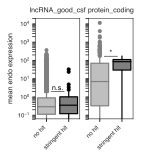

In [33]:
fig, axarr = plt.subplots(figsize=(1.75, 1.85), nrows=1, ncols=2, sharey=True)

for i, csf in enumerate(order):
    ax = axarr[i]
    sub = data_w_seq[data_w_seq["csf"] == csf]
    sns.boxplot(data=sub, x="is_hit", y="endo_mean",
                flierprops = dict(marker='o', markersize=3), order=hue_order, palette=pal, ax=ax)
    mimic_r_boxplot(ax)
    ax.set_xticklabels(hue_order, rotation=45, ha="right", va="top")
    ax.set_xlabel("")
    ax.set_ylabel("mean endo expression")
    ax.set_title(csf)
    if i != 0:
        ax.set_ylabel("")
    ax.set_yscale("log")
    
    # calc p-vals b/w dists
    dist1 = np.asarray(sub[sub["is_hit"] == "no hit"]["endo_mean"])
    dist2 = np.asarray(sub[sub["is_hit"] == "stringent hit"]["endo_mean"])

    dist1 = dist1[~np.isnan(dist1)]
    dist2 = dist2[~np.isnan(dist2)]

    u, pval = stats.mannwhitneyu(dist1, dist2, alternative="less", use_continuity=False)
    print(pval)
    
    # annotate pval
    if i == 0:
        annotate_pval(ax, 0.2, 0.8, 2, 0, 2, pval, fontsize)
    else:
        annotate_pval(ax, 0.2, 0.8, 170, 0, 170, pval, fontsize)

plt.subplots_adjust(wspace=0.2)
#fig.savefig("Fig5H.pdf", dpi="figure", bbox_inches="tight")

## 6. plot expression change v. enrichment score for stringent hits only

In [34]:
hits = data_w_seq[data_w_seq["is_hit"] == "stringent hit"]
experimental = hits[hits["ctrl_status_fixed"] == "experimental"]
control = hits[hits["ctrl_status_fixed"] == "control"]
control["gene_name"]

5348     SOX17
2749     EOMES
2748     EOMES
11764    FOXA2
8627       GSC
10644    GATA6
322      MIXL1
Name: gene_name, dtype: object

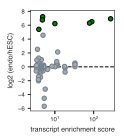

In [35]:
fig, ax = plt.subplots(figsize=(1.5,1.85), nrows=1, ncols=1)

ax.axhline(y=0, linestyle="dashed", color="black", linewidth=1, zorder=1)
ax.scatter(experimental["BFP+_score__mean"], experimental["endo_hESC_log2fc"], s=20,
            color="darkgray", alpha=1, linewidths=1, edgecolors="slategray", zorder=10)
ax.scatter(control["BFP+_score__mean"], control["endo_hESC_log2fc"], s=20,
            color="green", alpha=1, linewidths=1, edgecolors="black", zorder=11)
ax.set_xlabel("transcript enrichment score")
ax.set_ylabel("log2 (endo/hESC)")
ax.set_xscale('symlog')
#fig.savefig("Fig5I.pdf", dpi="figure", bbox_inches="tight")

## 7. mark hits in all RNA-seq data

In [36]:
no_na = data_w_seq[~pd.isnull(data_w_seq["qval_hESC_endo"])]
no_na = no_na[~no_na["qval_hESC_endo"].str.contains("NA")]
no_na["qval_log10_hESC_endo"] = -np.log10(no_na["qval_hESC_endo"].astype(float))
len(no_na)

9406

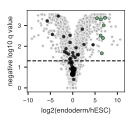

In [37]:
fig = plt.figure(figsize=(1.75, 1.5))

ncRNA = no_na[no_na["ctrl_status_fixed"] == "experimental"]
mRNA = no_na[no_na["ctrl_status_fixed"] == "control"]

ncRNA_hits = ncRNA[ncRNA["is_hit"] == "stringent hit"]
ctrl_hits = mRNA[mRNA["is_hit"] == "stringent hit"]

ax = sns.regplot(x="endo_hESC_log2fc", y="qval_log10_hESC_endo", data=no_na, fit_reg=False, 
                 color="darkgray", scatter_kws={"s": 8, "edgecolors": "white", "linewidths": 0.5})
sns.regplot(x="endo_hESC_log2fc", y="qval_log10_hESC_endo", data=ctrl_hits, fit_reg=False, 
            color=sns.color_palette()[2], scatter_kws={"s": 10, "edgecolors": "black", "linewidths": 0.5}, ax=ax)
sns.regplot(x="endo_hESC_log2fc", y="qval_log10_hESC_endo", data=ncRNA_hits, fit_reg=False, 
            color="black", scatter_kws={"s": 8, "edgecolors": "black", "linewidths": 0.5}, ax=ax)


plt.xlabel("log2(endoderm/hESC)")
plt.ylabel("negative log10 q value")
# plt.ylim((-0.1, 4))
# plt.xlim((-8.5, 8.5))
plt.axhline(y=-np.log10(0.05), linestyle="dashed", color="black", linewidth=1)
#plt.title("volcano plot for ncRNAs in endoderm vs. hESCs\n(n=%s)" % (len(diff_hESC_endo_ncRNA)))
plt.savefig("Fig5J.pdf", bbox_inches="tight", dpi="figure")

## 6. write file

In [38]:
f = "../../../data/02__screen/02__enrichment_data/enrichment_values.with_rna_seq.txt"

In [39]:
data_w_seq.columns

Index(['group_id', 'ctrl_status', 'endo_ctrl_val', 'BFP+_score__rep1',
       'BFP+_score_rank__rep1', 'BFP+_score__rep2', 'BFP+_score_rank__rep2',
       'BFP+_score__mean', 'BFP+_score_rank__mean', 'ctrl_status_fixed',
       'pval__rep1', 'pval__rep2', 'combined_pval', 'padj', 'neg_log_padj',
       'tss_id', 'gene_name', 'gene_id', 'transcript_name', 'transcript_id',
       'csf', 'cleaner_gene_biotype', 'cleaner_transcript_biotype',
       'hESC_rep1', 'hESC_rep2', 'endo_rep1', 'endo_rep2', 'meso_rep1',
       'meso_rep2', 'hESC_mean', 'endo_mean', 'threshold', 'qval_hESC_endo',
       'endo_hESC_log2fc', 'is_hit', 'endo_hESC_abslog2fc'],
      dtype='object')

In [40]:
data_w_seq = data_w_seq[["group_id", "ctrl_status", "endo_ctrl_val", "gene_name", "gene_id", "transcript_name",
                         "transcript_id", "cleaner_transcript_biotype", "cleaner_gene_biotype", "BFP+_score__rep1", 
                         "BFP+_score_rank__rep1", "pval__rep1", 
                         "BFP+_score__rep2", "BFP+_score_rank__rep2", "pval__rep2", "BFP+_score__mean", 
                         "BFP+_score_rank__mean", "combined_pval", "padj", "neg_log_padj", "is_hit",
                         "csf", "hESC_mean", "endo_mean", "qval_hESC_endo", "endo_hESC_log2fc",
                         "endo_hESC_abslog2fc"]]
data_w_seq.head()

group_id   ctrl_status  endo_ctrl_val     gene_name  \
5348  NC_000008.11:+:54457934       control           True         SOX17   
2749  NC_000003.12:-:27722707       control           True         EOMES   
2748  NC_000003.12:-:27722322       control           True         EOMES   
9203  NC_000016.10:+:23452748  experimental          False  CTD-2270L9.4   
9204  NC_000016.10:+:23452748  experimental          False  CTD-2270L9.4   

                   gene_id   transcript_name        transcript_id  \
5348   ENSG00000164736.5_1         SOX17-001  ENST00000297316.4_1   
2749  ENSG00000163508.12_1         EOMES-004  ENST00000461503.2_1   
2748  ENSG00000163508.12_1         EOMES-001  ENST00000295743.8_1   
9203   ENSG00000260136.5_1  CTD-2270L9.4-003  ENST00000565747.5_1   
9204   ENSG00000260136.5_1  CTD-2270L9.4-001  ENST00000570080.1_1   

     cleaner_transcript_biotype cleaner_gene_biotype  BFP+_score__rep1  \
5348             protein_coding       protein_coding        232.279434   
2749             protein_coding       protein_coding        156.570722   
2748             protein_coding       protein_coding         43.594914   
9203           promoter_overlap     promoter_overlap          3.702626   
9204           promoter_overlap     promoter_overlap          3.702626   

             ...           combined_pval      padj  neg_log_padj  \
5348         ...                0.000002  0.000284      3.546586   
2749         ...                0.000002  0.000284      3.546586   
2748         ...                0.000002  0.000284      3.546586   
9203         ...                0.000173  0.009619      2.016871   
9204         ...                0.000173  0.009619      2.016871   

             is_hit              csf  hESC_mean   endo_mean  \
5348  stringent hit   protein_coding   0.110290  134.426513   
2749  stringent hit   protein_coding   0.123413  101.207791   
2748  stringent hit   protein_coding   0.084601   85.188250   
9203  stringent hit  lncRNA_good_csf   0.956400    0.999846   
9204  stringent hit  lncRNA_good_csf   1.391981    2.482487   

            qval_hESC_endo  endo_hESC_log2fc  endo_hESC_abslog2fc  
5348  0.000991006472787698          6.930430             6.930430  
2749    0.0217931946808208          6.507473             6.507473  
2748  0.000510199113682609          6.312255             6.312255  
9203   0.18145252810327697          0.031688             0.031688  
9204    0.0347336116955254          0.541912             0.541912  

[5 rows x 27 columns]

In [41]:
data_w_seq = data_w_seq.sort_values(by="BFP+_score__mean", ascending=False)
data_w_seq.to_csv(f, sep="\t", index=False)